# **Generated Content Detector Project: AI generated photos vs real photos**
# **Transfer Learning - ResNet Model**


## **Importing Libraries**

In [1]:
pip install --upgrade torchinfo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from typing import List, Tuple
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer
import random
from sklearn.metrics import classification_report
print(torch.cuda.is_available())

True


## **Downloading the dataset**
###### The !gdown command downloads a specific file from Google Drive directly into the current working directory of the Jupyter notebook, using its unique file ID.




In [3]:
!gdown 1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL

Downloading...
From (original): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL
From (redirected): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL&confirm=t&uuid=086e54fd-c94e-485d-9f1e-5c0536b094ef
To: /content/AI-face-detection-Dataset-v3.zip
100% 1.12G/1.12G [00:21<00:00, 51.9MB/s]


###### The !unzip command extracts the contents of the ZIP file above, decompressing the files into the current directory.

In [ ]:
!unzip /content/AI-face-detection-Dataset-v3.zip

## **Determining Optimal System Device for Performance: CPU vs. CUDA (VRAM)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## **Preparing Image Datasets with PyTorch.**
##### **- Training Data: 7,000 images (3500 AI + 3500 real) - 70%**
##### **- Testing Data: 2,000 images (1000 AI + 1000 real) - 20%**
##### **- Testing Data: 1,000 images (500 AI + 500 real) - 10%**

In [6]:
# Measure the time taken for the cell execution:
%%time

# Set up image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the specified directory
dataset = datasets.ImageFolder("/content/AI-face-detection-Dataset-v3/", transform=transform)

# Load previously saved indices or datasets if available:
try:
    with open('datasets.pkl', 'rb') as f:
        data = pickle.load(f)
        train_indices = data['train_indices']
        val_indices = data['val_indices']
        test_indices = data['test_indices']
        classes = data['classes']
except FileNotFoundError:
    print("No saved dataset found, proceeding with the current run.")

# If loading fails, do the following steps:

# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

# Prepare subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)  # Validation loader
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Retrieve class names
classes = dataset.classes   # ['ai', 'real']

# Output the number of samples in training, validation, and testing datasets
print("Train samples:", len(train_indices))
print("Validation samples:", len(val_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

# Save the datasets and indices:
with open('datasets.pkl', 'wb') as f:
    pickle.dump({
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices,
        'classes': classes
    }, f)

No saved dataset found, proceeding with the current run.
Train samples: 6996
Validation samples: 998
Test samples: 2002
Classes: ['AI', 'real_color']
CPU times: user 9min 23s, sys: 1.93 s, total: 9min 24s
Wall time: 2min 29s


## **Setting up a pretrained model - 'ResNet18'**

In [7]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ResNet18_Weights.DEFAULT # Selects the best available weights
model = torchvision.models.resnet18(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 242MB/s]


## **Getting a summary of our model with torchinfo.summary()**
###### Overall, the ResNet-18 model is well-structured and efficient, with a substantial number of parameters that enable high performance in tasks such as content detection. The shapes of inputs and outputs reflect the architecture’s adaptability, while the total parameter count indicates a balance between complexity and efficiency.

In [8]:
summary(model=model,
        input_size=(8, 3, 128, 128), # The size of the input tensor (batch size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"], # Specifies the columns to display in the summary
        col_width=20, # Sets the width of the columns in the summary output
        row_settings=["var_names"]) # Includes variable names in the summary rows for clarity

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [8, 3, 128, 128]     [8, 1000]            --                   True
├─Conv2d (conv1)                         [8, 3, 128, 128]     [8, 64, 64, 64]      9,408                True
├─BatchNorm2d (bn1)                      [8, 64, 64, 64]      [8, 64, 64, 64]      128                  True
├─ReLU (relu)                            [8, 64, 64, 64]      [8, 64, 64, 64]      --                   --
├─MaxPool2d (maxpool)                    [8, 64, 64, 64]      [8, 64, 32, 32]      --                   --
├─Sequential (layer1)                    [8, 64, 32, 32]      [8, 64, 32, 32]      --                   True
│    └─BasicBlock (0)                    [8, 64, 32, 32]      [8, 64, 32, 32]      --                   True
│    │    └─Conv2d (conv1)               [8, 64, 32, 32]      [8, 64, 32, 32]      36,864               True
│    │    └─BatchN

## **Freezing All Layers of the Base Model Except the Last Three Layers**
###### The model summary illustrates the notable transformations in input and output shapes as the image data navigates through the ResNet architecture. Boasting a total of 11,689,512 parameters, this model is well-prepared to identify a wide range of patterns within the data. The plan is to freeze the majority of the base model to retain learned features, prevent overfitting, and ensure faster training. This will allow the model to maintain stability in learning while focusing on task-specific adaptations. Selectively unfreezing the last layers will enable fine-tuning for specific tasks, thereby enhancing performance in the application.

In [9]:
for param in model.parameters():
    param.requires_grad = False # Freeze all base layers

### **Unfreezing `model.layer3` for Fine-tuning**

In [10]:
# Unfreeze parameters in model.layer3
for param in model.layer3.parameters():
    param.requires_grad = True

print("Parameters in model.layer3 are now unfrozen.")

Parameters in model.layer3 are now unfrozen.


### **Model Summary After Unfreezing `model.layer3` and `model.fc`**

Let's re-examine the model summary to see the updated number of trainable parameters after unfreezing `model.layer3` (in addition to the `fc` layer).

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of classes (one output unit for each class)
output_shape = len(classes)

# Recreate the final fully connected layer (fc) for ResNet18 and send it to the target device
# ResNet18's final layer is named 'fc', and its input features are 512 after the AdaptiveAvgPool2d.
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=512, # ResNet18's 'fc' layer takes 512 in_features
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [12]:
# Do a summary *after* unfreezing model.layer3 and model.fc
summary(model,
        input_size=(8, 3, 128, 128), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [8, 3, 128, 128]     [8, 2]               --                   Partial
├─Conv2d (conv1)                         [8, 3, 128, 128]     [8, 64, 64, 64]      (9,408)              False
├─BatchNorm2d (bn1)                      [8, 64, 64, 64]      [8, 64, 64, 64]      (128)                False
├─ReLU (relu)                            [8, 64, 64, 64]      [8, 64, 64, 64]      --                   --
├─MaxPool2d (maxpool)                    [8, 64, 64, 64]      [8, 64, 32, 32]      --                   --
├─Sequential (layer1)                    [8, 64, 32, 32]      [8, 64, 32, 32]      --                   False
│    └─BasicBlock (0)                    [8, 64, 32, 32]      [8, 64, 32, 32]      --                   False
│    │    └─Conv2d (conv1)               [8, 64, 32, 32]      [8, 64, 32, 32]      (36,864)             False
│    │    

###### The primary change after freezing/unfreezing is a significant reduction in trainable parameters from 11,177,538 to 2,100,738, indicating that only certain layers are now updated during training, while 9,076,800 parameters remain frozen. This approach retains learned features in the base layers, reducing the risk of overfitting, while still leveraging the model's computational capacity as indicated by the constant total mult-adds and estimation sizes. The unchanged input size and forward/backward pass sizes suggest that the model’s computational efficiency remains intact, facilitating quicker training iterations while focusing on task-specific learning in the unfrozen layers.


## **Training the model**

In [13]:
# Define the loss function for training
loss_fn = nn.CrossEntropyLoss() # This is used for multi-class classification

# Set up the optimizer for updating the model's parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent with momentum

# Alternative optimizer: Adam optimizer for adaptive learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
#ENGINE
"""
Contains functions for training and testing a PyTorch model.
"""

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy).
    For example:(0.1112, 0.8743)
    """
    # Put model in train mode to enable training features
    model.train()

    # Initialize train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through batches of data from the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # # Send data to the specified target device (GPU/CPU)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass: get predictions from the model
        y_pred = model(X)

        # 2. Calculate and accumulate loss using the loss function
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # Accumulate loss for average calculation

        # # 3. Optimizer zero grad: clear old gradients
        optimizer.zero_grad()

        # 4. Loss backward: compute gradients of loss with respect to model parameters
        loss.backward()

        # 5. . Optimizer step: update model parameters based on gradients
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader) # Average loss over batches
    train_acc = train_acc / len(dataloader) # Average accuracy over batches
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).
    For example: (0.0223, 0.8985)
    """
    # Put model in eval mode to deactivate dropout layers and batch norm behavior
    model.eval()

    # Initialize test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager to save memory during inference
    with torch.inference_mode():
        # Loop through DataLoader batches for testing
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the specified target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass: get predictions from the model
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item() # Accumulate loss for average calculation

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [15]:
# Set the random seeds for reproducibility in training
torch.manual_seed(42)       # Set seed for CPU
torch.cuda.manual_seed(42)  # Set seed for GPU

# Start the timer to measure training duration
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=trainloader,  # DataLoader for training data
                       test_dataloader=valloader, # DataLoader for validation/testing data
                       optimizer=optimizer, # Optimizer for model training
                       loss_fn=loss_fn, # Loss function to evaluate model performance
                       epochs=8, # Number of training epochs
                       device=device) # Device to perform training (CPU or GPU)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2928 | train_acc: 0.8783 | test_loss: 0.1031 | test_acc: 0.9668
Epoch: 2 | train_loss: 0.1334 | train_acc: 0.9515 | test_loss: 0.0691 | test_acc: 0.9756
Epoch: 3 | train_loss: 0.0789 | train_acc: 0.9717 | test_loss: 0.0593 | test_acc: 0.9782
Epoch: 4 | train_loss: 0.0490 | train_acc: 0.9822 | test_loss: 0.0506 | test_acc: 0.9785
Epoch: 5 | train_loss: 0.0361 | train_acc: 0.9869 | test_loss: 0.0436 | test_acc: 0.9883
Epoch: 6 | train_loss: 0.0270 | train_acc: 0.9927 | test_loss: 0.0451 | test_acc: 0.9785
Epoch: 7 | train_loss: 0.0187 | train_acc: 0.9937 | test_loss: 0.0387 | test_acc: 0.9912
Epoch: 8 | train_loss: 0.0145 | train_acc: 0.9953 | test_loss: 0.0352 | test_acc: 0.9902
[INFO] Total training time: 233.979 seconds


## **Learning Curve**

In [16]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

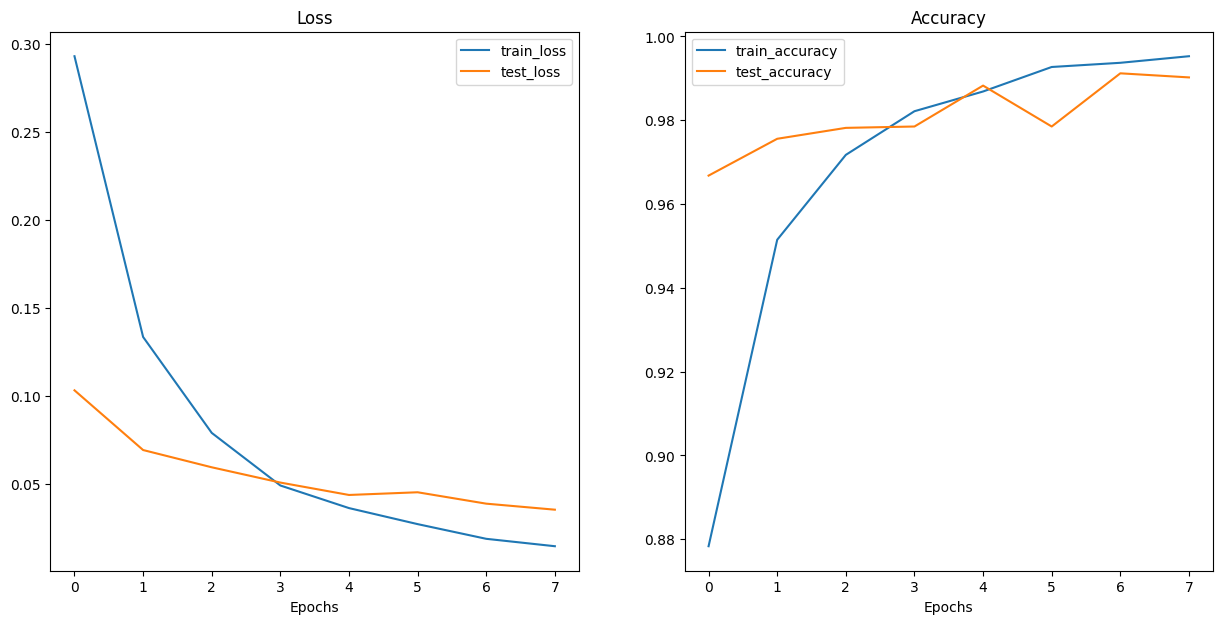

In [17]:
# Plot the loss curves of our model
plot_loss_curves(results)

###### The learning curves for ResNet18 show a steady decrease in training loss and a corresponding improvement in training accuracy, indicating effective learning and a good fit to the training data. The test loss also trends downward, suggesting strong generalization to unseen data, while the test accuracy approaches near-perfect values. The close alignment of training and test metrics implies minimal overfitting, affirming that the model is well-tuned for the task at hand. Overall, these curves demonstrate the model's robustness and make a compelling case for its application in image classification and related tasks.

## **Validation Accuracy**

In [18]:
# Load the best saved model
# The 'Net' class is not defined, using the 'model' variable from previous cells.
best_model = model
# The model is already loaded and trained, so no need to load state dict again.
# best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_val_accuracy = correct / total
print(f"Final Validation Accuracy (best model): {final_val_accuracy:.4f}")

Final Validation Accuracy (best model): 0.9900


###### The final validation accuracy indicates that the model performed exceptionally well, successfully classifying 99% of the validation samples correctly. This high accuracy demonstrates strong generalization capabilities and suggests that the model is well-suited for the task, minimizing errors on unseen data.

## **Testing the Network on Test Data**


#### Preparing and Predicting Test Images


In [19]:
model.eval() # Set the model to evaluation mode

dataiter = iter(testloader)  # Create an iterator for the test data loader
images, true_labels = next(dataiter)  # Get a batch of images and their true labels

images = images.to(device)  # Move images to the appropriate device

# Perform a forward pass and get predictions without calculating gradients
with torch.no_grad():
    outputs = model(images)

_, predicted_labels = torch.max(outputs, 1) # Get the predicted class indices

print("Retrieved a batch of test images and generated predictions.")
print(f"Number of images in batch: {len(images)}")
print(f"True labels (first 10): {true_labels[:10].tolist()}")
print(f"Predicted labels (first 10): {predicted_labels[:10].tolist()}")

Retrieved a batch of test images and generated predictions.
Number of images in batch: 32
True labels (first 10): [0, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Predicted labels (first 10): [0, 1, 1, 1, 0, 0, 1, 0, 0, 1]


#### Displaying Images with Actual and Predicted Labels


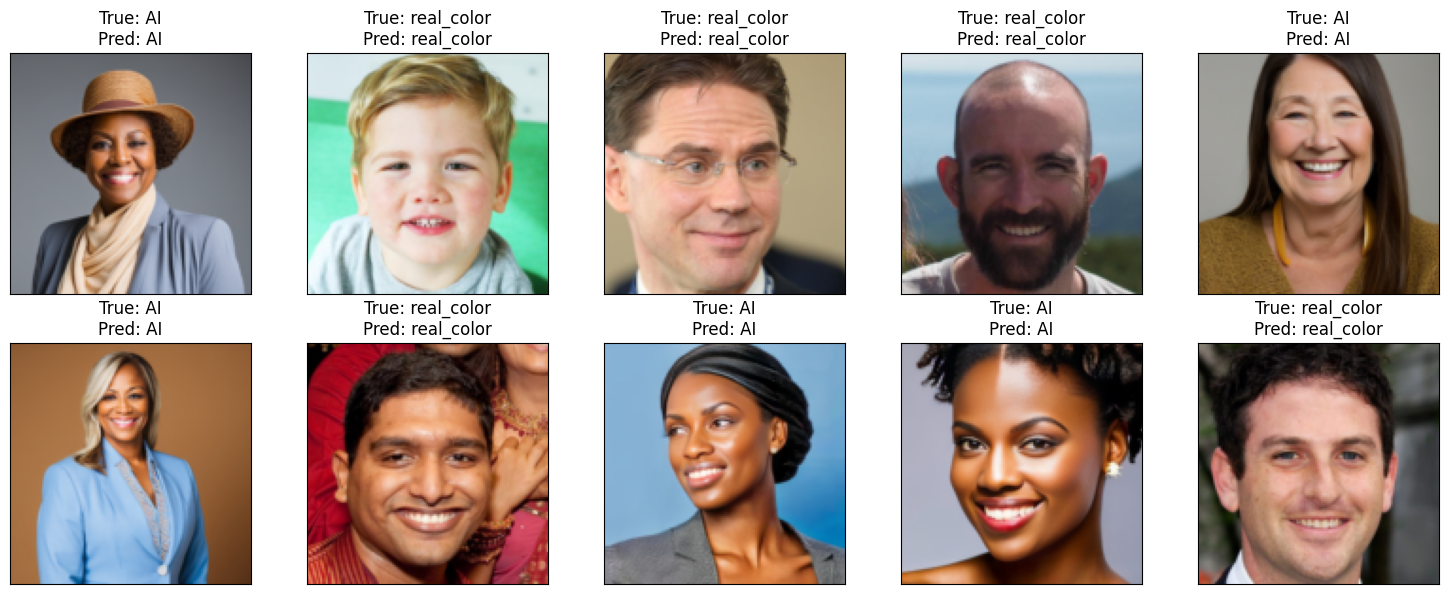

In [20]:
num_display = 10

fig = plt.figure(figsize=(15, 6))

for idx in range(num_display):
    ax = fig.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])

    # Unnormalize the image and transpose dimensions
    img_display = images[idx].cpu().numpy()
    img_display = img_display / 2 + 0.5
    img_display = np.transpose(img_display, (1, 2, 0))

    # Display the image
    ax.imshow(img_display)

    # Set title with true and predicted labels
    ax.set_title(f"True: {classes[true_labels[idx]]}\nPred: {classes[predicted_labels[idx]]}")

plt.tight_layout()
plt.show()

## **Evaluating Network Performance on the Entire Dataset**
### **Overall Accuracy**

In [21]:
correct = 0  # Initialize a counter for correctly classified images
total = 0    # Initialize a counter for the total number of images

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:  # Iterate through batches of test data
        images, labels = data  # Get images and their corresponding labels

        # Move inputs to the appropriate device for processing
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by passing images through the network
        outputs = model(images)

        # Determine the predicted class by finding the index of the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Update the total number of images processed
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print the accuracy of the network on the test dataset
accuracy = 100 * correct / total if total > 0 else 0  # Prevent division by zero
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')  # Print accuracy formatted to two decimal places

Accuracy of the network on the test images: 98.90 %


###### The test accuracy of 98.90% shows that the model reliably classifies nearly all unseen samples correctly, confirming its strong performance and generalization ability.

### **Classification Report**

In [22]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=classes)

# Print the report
print(report)

              precision    recall  f1-score   support

          AI       0.99      0.99      0.99      1001
  real_color       0.99      0.99      0.99      1001

    accuracy                           0.99      2002
   macro avg       0.99      0.99      0.99      2002
weighted avg       0.99      0.99      0.99      2002



###### The classification report shows excellent performance, with both classes achieving precision, recall, and F1-scores of 0.99, indicating minimal errors. The overall accuracy of 0.99 confirms the model's robustness in accurately classifying the dataset.

### **Confusion Matrix**

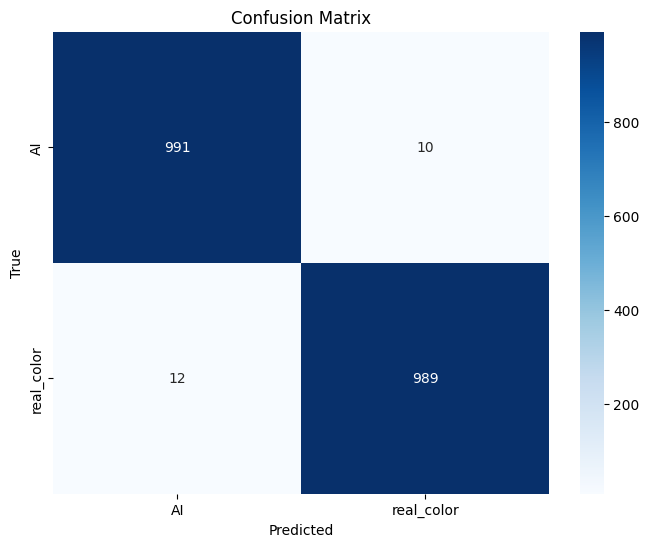

In [23]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###### The confusion matrix highlights strong model performance, correctly classifying 991 out of 1,001 "AI" images and 989 out of 1,001 "real" images. The low number of misclassifications - 10 false positives and 12 false negatives - demonstrates the model's effectiveness in distinguishing between the two classes.

#### **Summary:** The model exhibits outstanding performance, with a validation accuracy of 99.0% and a test accuracy of 98.9%. The classification report reveals high precision and recall values of 0.99 for both "AI" and "real" classes, showcasing effective identification. The confusion matrix further supports these findings, showing minimal misclassifications, which underscores the model's robust generalization capabilities and reliability in distinguishing between AI-generated and real images.